In [1]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"

In [2]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [3]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [4]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [6]:
# load tle data and order by time
document_file = 'Starlink_TLE/Single_Satellite_TLE'
satellite_name = 'STARLINK-1094'
tle_file = os.path.join(document_file, f'{satellite_name}.txt')
tle_data = []

with open(tle_file, 'r') as file:
    lines = file.readlines()
    i = 0
    while i < len(lines):
        if lines[i].startswith(satellite_name):
            tle1 = lines[i+1].strip()
            tle2 = lines[i+2].strip()
            tle_epoch = parse_tle_epoch(tle1.split()[3])
            tle_data.append((tle_epoch, tle1, tle2))
            i += 3
        else:
            i += 1

tle_data.sort(key=lambda x: x[0])  # 按历元时间排序

In [7]:
# gemerate time series
start_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 2, 0, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(minutes = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [8]:
# 计算每个时间点的卫星海拔
ts = load.timescale()
altitudes = []
latutudes = []
longitudes = []
times = []

tle_index = 0

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()
   
    altitude = subpoint.elevation.km
    altitudes.append(altitude)
    
    latitude = subpoint.latitude.degrees
    latutudes.append(latitude)

    
    longitude = subpoint.longitude.degrees
    longitudes.append(longitude)

    
    times.append(current_time)

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming latitudes, longitudes, and times have been computed as in your code

# Load the world map using GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360)+90 if lon > 90 else lon+90 for lon in longitudes]

track_latutudes = []
track_longitudes = []


track_latutude = []
track_longitude = []
# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:

        track_latutude.append(latutudes[i])
        track_longitude.append(longitudes[i])
            
        
    else:
        
        track_latutudes.append(track_latutude)
        track_longitudes.append(track_longitude)
        track_latutude = []
        track_longitude = []
        


C:\Users\ycgao\AppData\Local\Temp\ipykernel_40296\3854064817.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


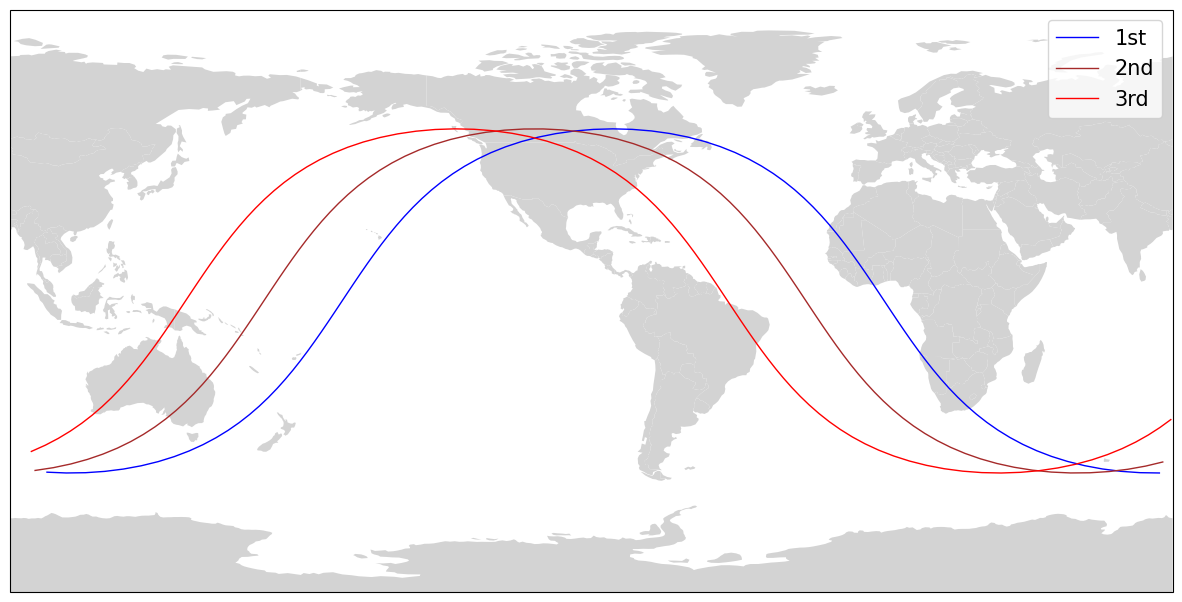

In [22]:
# Create a figure and axis with a Cartopy projection centered on -90 degrees (Americas)
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-90)})

# Plot the world map using GeoPandas with the specified projection
world.plot(ax=ax, color='lightgrey', transform=ccrs.PlateCarree())

#for track_latutude, track_longitude in zip(track_latutudes, track_longitudes):
    #ax.plot(track_longitude, track_latutude, color='blue', linewidth=1, transform=ccrs.Geodetic())
ax.plot(track_longitudes[1], track_latutudes[1], color='blue', linewidth=1, transform=ccrs.Geodetic(), label='1st')
ax.plot(track_longitudes[2], track_latutudes[2], color='brown', linewidth=1, transform=ccrs.Geodetic(), label='2nd')
ax.plot(track_longitudes[3], track_latutudes[3], color='red', linewidth=1, transform=ccrs.Geodetic(), label='3rd')

# Add coastlines and gridlines for better context
#ax.coastlines()
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Add title and labels
#ax.set_title('Satellite Ground Track Split at Longitude -100°', fontsize=15)
ax.legend(fontsize=15)

# Show the plot
plt.show()


In [19]:
track_longitudes = []